In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd "drive/My Drive/Datasets"

/content/drive/My Drive/Datasets


# Importing The Modules

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Reading The Dataset

In [4]:
filepath = "/content/drive/MyDrive/Datasets/Sentiment140.csv"
dataset = pd.read_csv(filepath, encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])

In [5]:
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [6]:
dataset.head(-5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599990,4,2193579249,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,razzberry5594,WOOOOO! Xbox is back
1599991,4,2193579284,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,AgustinaP,@rmedina @LaTati Mmmm That sounds absolutely ...
1599992,4,2193579434,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,sdancingsteph,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
1599993,4,2193579477,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,ChloeAmisha,@SCOOBY_GRITBOYS


In [7]:
dataset.replace({'target':{4:1}}, inplace=True)

### Mapping Target Labels To Sentiments
### 0 -> Negative
### 1 -> Positive

In [8]:
label_map = {0: "NEGATIVE", 1: "POSITIVE"}
def label_sentiment(label):
    return label_map[int(label)]

dataset['target'] = dataset['target'].apply( lambda x: label_sentiment(x))


In [9]:
dataset['target'].head(-5)

0          NEGATIVE
1          NEGATIVE
2          NEGATIVE
3          NEGATIVE
4          NEGATIVE
             ...   
1599990    POSITIVE
1599991    POSITIVE
1599992    POSITIVE
1599993    POSITIVE
1599994    POSITIVE
Name: target, Length: 1599995, dtype: object

Text(0.5, 1.0, 'Dataset labels distribuition')

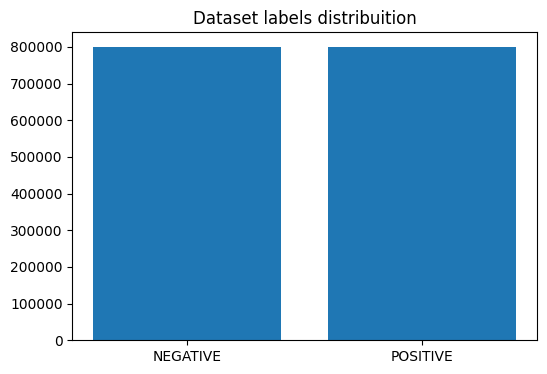

In [10]:
value_counter = Counter(dataset['target'])
plt.figure(figsize=(6,4))
plt.bar(value_counter.keys(), value_counter.values())
plt.title("Dataset labels distribuition")

#  Data PreProcessing

In [11]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def preprocess(text, stem=False):
  # Removing the Links , user mentions and special characters
  text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text))
  text = text.lower()
  text = text.strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [13]:
dataset['clean_text'] = dataset['text'].apply(lambda x: preprocess(x))


In [14]:
dataset['clean_text'].head(-5)

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599990                                     wooooo xbox back
1599991    latati mmmm sounds absolutely perfect schedule...
1599992                              recovering long weekend
1599993                                                     
1599994    yeah work better waiting end wonder time keep ...
Name: clean_text, Length: 1599995, dtype: object

# Splitting the Dataset into Training set and Test Set

In [15]:
selected_columns = ['clean_text', 'target']
new_dataset = dataset[selected_columns].iloc[650000:950001]

In [16]:
X = new_dataset['clean_text'].values
y = new_dataset['target'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


## Word2Vec

In [18]:
documents = [ _clean_text.split() for _clean_text in X_train]

In [19]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size = 300, window = 7, min_count = 10, workers = 8)
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 11245


In [21]:
w2v_model.train(documents, total_examples = len(documents), epochs = 32)

(46772484, 55393440)

In [22]:
w2v_model.wv.most_similar('style')

[('facial', 0.33342310786247253),
 ('funky', 0.32562196254730225),
 ('stylist', 0.3253740966320038),
 ('color', 0.322731614112854),
 ('humor', 0.31876736879348755),
 ('model', 0.3163774609565735),
 ('dye', 0.31326210498809814),
 ('designer', 0.3120401203632355),
 ('hat', 0.3114665746688843),
 ('recipes', 0.31105247139930725)]

### Tokenizing

In [23]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

## Padding

In [24]:
maxlen = 300
X_train = pad_sequences(X_train , maxlen=maxlen)
X_test = pad_sequences(X_test , maxlen=maxlen)

In [25]:
vocab_length = len(word_tokenizer.word_index) + 1
print('Vocab Length:', vocab_length)

Vocab Length: 97678


## Label Encoding

In [26]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [27]:
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (240000, 300)
y_train (240000, 1)

x_test (60001, 300)
y_test (60001, 1)


## Embedding Layer

In [28]:
# Creating the Embedding Matrix
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    if word in w2v_model.wv:
      embedding_matrix[index] = w2v_model.wv[word]
print(embedding_matrix.shape)

(97678, 300)


# Building The LSTM Model

In [29]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm.add(embedding_layer)
lstm.add(Dropout(0.5))
lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

lstm.add(Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          29303400  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 29463901 (112.40 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 29303400 (111.78 MB)
_________________________________________________________________


## Compiling the Model

In [30]:
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
lstm.fit(X_train, y_train, epochs=8, batch_size=128, verbose=1, validation_split = 0.1)

Epoch 1/8
1688/1688 [==============================] - 3717s 2s/step - loss: 0.5196 - accuracy: 0.7386 - val_loss: 0.4768 - val_accuracy: 0.7688
Epoch 2/8
1688/1688 [==============================] - 3713s 2s/step - loss: 0.4894 - accuracy: 0.7590 - val_loss: 0.4699 - val_accuracy: 0.7732
Epoch 3/8
1688/1688 [==============================] - 3742s 2s/step - loss: 0.4809 - accuracy: 0.7653 - val_loss: 0.4653 - val_accuracy: 0.7762
Epoch 4/8
1688/1688 [==============================] - 3850s 2s/step - loss: 0.4766 - accuracy: 0.7678 - val_loss: 0.4688 - val_accuracy: 0.7780
Epoch 5/8
1688/1688 [==============================] - 3739s 2s/step - loss: 0.4731 - accuracy: 0.7690 - val_loss: 0.4669 - val_accuracy: 0.7780
Epoch 6/8
1688/1688 [==============================] - 3700s 2s/step - loss: 0.4705 - accuracy: 0.7710 - val_loss: 0.4625 - val_accuracy: 0.7793
Epoch 7/8
1688/1688 [==============================] - 3709s 2s/step - loss: 0.4677 - accuracy: 0.7735 - val_loss: 0.4613 - val_ac

# Evaluation Metrics

In [37]:
!pip install sns

  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2639 sha256=c105c0c0e1eea6b2defb523d36a08488c3fcc1f10e7f189cd4cfcfc7c70b2a0a
  Stored in directory: /root/.cache/pip/wheels/76/1a/47/c3b6a8b9d3ae47b1488f4be13c86586327c07e0ac1bb5b3337
Successfully built sns


In [ ]:
import sns
y_pred = lstm.predict(X_test)
y_pred = encoder.fit_transform(y_pred)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.colorbar()
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

#print(cm)
#accuracy_score(y_test, y_pred)

1876/1876 [==============================] - 261s 139ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
score = lstm.evaluate(X_test, y_test, verbose = 1)
print('Loss Score:', score[0])
print('Accuracy Score:', score[1])

1876/1876 [==============================] - 263s 140ms/step - loss: 0.4582 - accuracy: 0.7842
Loss Score: 0.45823192596435547
Accuracy Score: 0.784220278263092


# Saving The Model

In [ ]:
lstm.save('lstm_model.h5')